In [37]:
import sys
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import itertools
import lmfit
from astropy.convolution import Gaussian2DKernel
from astropy.visualization import MinMaxInterval,SqrtStretch,AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import make_lupton_rgb
sys.path.append('/Users/liruancun/Works/GitHub/')
from MorphSED.morphsed import Galaxy, AGN, Galaxy3D
from astropy.modeling.models import Sersic2D
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM,z_at_value
from astropy.stats import sigma_clipped_stats
from astropy.visualization.mpl_normalize import simple_norm
from MorphSED.morphsed import sed_interp
import time,csv

In [10]:

Mygalaxy = Galaxy3D(mass = 1e11,z=0.03,ebv_G=0.07)



In [22]:
names  = ['%s_%s' % (profile, prop) for prop,profile in itertools.product(('xcen','ycen','mag','re','nser','ang','axrat','box'), ('sersic1','sersic2'))]
model0 = np.array((50, 50, 50, 50, 30., 70., 10, 35, 3.0, 1.0, 180/np.pi-90, 180/np.pi-90, 1.,    0.5, 0,     0))
tofit  = np.array((True,  False, True,  False, True,  True,  True, True, True, False, True,  True,  True, True,  False,  False))
params = np.array(model0[tofit])
allparams = model0.copy()
fields = ['xcen','ycen','frac','re','nser','ang','axrat','box']
s1params = [x for i,x in enumerate(allparams) if i%2 == 0]
s2params = [x for i,x in enumerate(allparams) if i%2 != 0]
fields.append('convolve')
s1params.append(False)
s2params.append(False)
sparams = [{name: val for name, val in zip(fields, params)} for params in (s1params, s2params)]
print (sparams[0])
print (sparams[1])

{'xcen': 50.0, 'ycen': 50.0, 'frac': 30.0, 're': 10.0, 'nser': 3.0, 'ang': -32.70422048691768, 'axrat': 1.0, 'box': 0.0, 'convolve': False}
{'xcen': 50.0, 'ycen': 50.0, 'frac': 70.0, 're': 35.0, 'nser': 1.0, 'ang': -32.70422048691768, 'axrat': 0.5, 'box': 0.0, 'convolve': False}


In [23]:
age = {'type': "linear", 'paradic':{'k':-0.05, 'b':9.}}
Z = {'type': "linear", 'paradic':{'k':0., 'b':0.02}}
f_cont = {'type': "const", 'paradic':{'value': 0.05}}
Av = {'type': "const", 'paradic':{'value': 1.5}}
sigma = {'type': "const", 'paradic':{'value': 150}}
Mygalaxy.add_subC('sersic',sparams[0],age,Z,f_cont,Av,sigma)
age = {'type': "linear", 'paradic':{'k':0., 'b':0.1}}
Z = {'type': "linear", 'paradic':{'k':0., 'b':0.05}}
f_cont = {'type': "const", 'paradic':{'value': 0.85}}
Av = {'type': "const", 'paradic':{'value': 1.0}}
sigma = {'type': "const", 'paradic':{'value': 80}}
Mygalaxy.add_subC('sersic',sparams[1],age,Z,f_cont,Av,sigma)


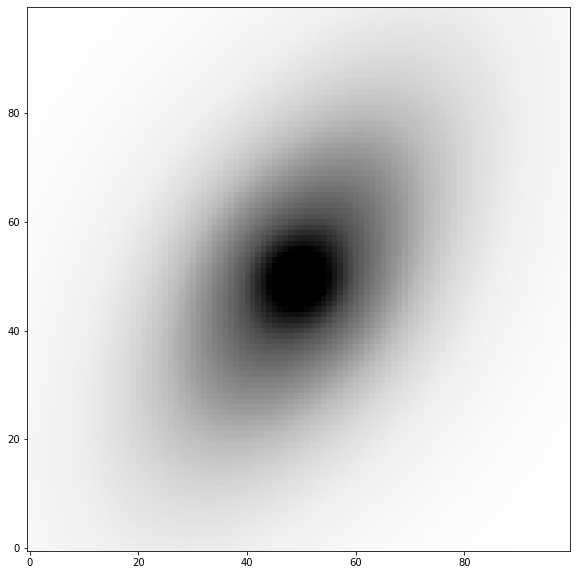

In [24]:
psfFWHM=1.44
psf = Gaussian2DKernel(psfFWHM, x_size=15, y_size=15)
psf.normalize()
totalmass = Mygalaxy.generate_mass_map((100,100),np.array(psf))
sky_mean=np.mean(totalmass)
sky_median=np.median(totalmass) 
sky_std = np.std(totalmass)
fig=plt.figure(figsize=(10,10))
norm=ImageNormalize(vmin=0.,vmax=(sky_median+4*sky_std),stretch=AsinhStretch())
plt.imshow(totalmass, cmap='Greys', origin='lower', norm=norm)
plt.show()

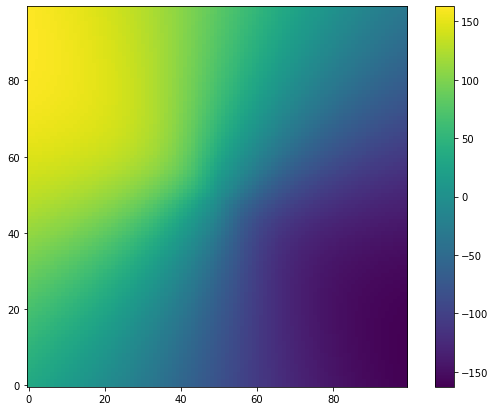

In [25]:
r_curve = {
    'function_name':'arctan',
    'params':{'v0':0.,'vc':220.,'r0':0.,'rt':20.,},
}
geometry = {
            'xcen' : 50.,
            'ycen' : 50., # in pix
            'i'  :  60.,      # in degree
            'PA' :  57.3, # in degree
            'rotation_curve': r_curve, # {'function_name','params'}
        }
v_map = Mygalaxy.geometry_3D(geometry)
fig=plt.figure(figsize=(10,7))
cb = plt.imshow(v_map, origin='lower')
plt.colorbar(cb)
plt.show()

In [26]:
wavelength = np.linspace(3500,7000,2000)
start_t = time.time()
IFU = Mygalaxy.generate_SED_IFU(wavelength,resolution=10)
stop_t = time.time()
print ("elapse time {0:.2f} s".format(stop_t-start_t))

elapse time 12.69 s


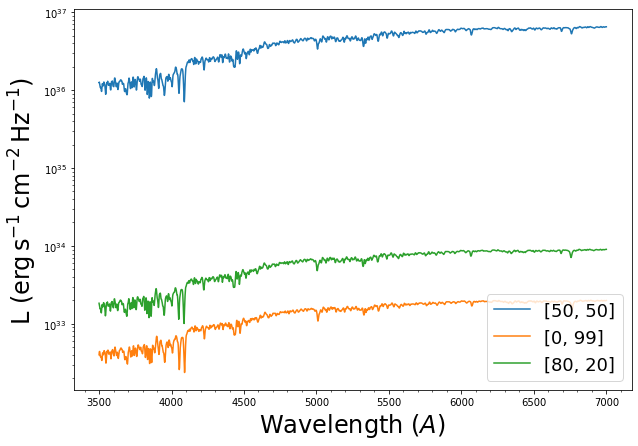

In [27]:
pixels = [[50,50],[0,99],[80,20]]
fig = plt.figure(figsize=(10, 7))
ax = plt.gca()
for loop, f in enumerate(pixels):
    ax.plot(wavelength, IFU[:,f[1],f[0]], color='C{0}'.format(loop), label='{0}'.format(f))
ax.legend(loc='lower right', fontsize=18)
ax.set_yscale('log')
#ax.set_ylim([1e-23, 5e-21])
ax.set_xlabel(r'Wavelength ($A$)', fontsize=24)
ax.set_ylabel(r'L ($\mathrm{erg\,s^{-1}\,cm^{-2}\,Hz^{-1}}$)', fontsize=24)
ax.minorticks_on()
plt.show()

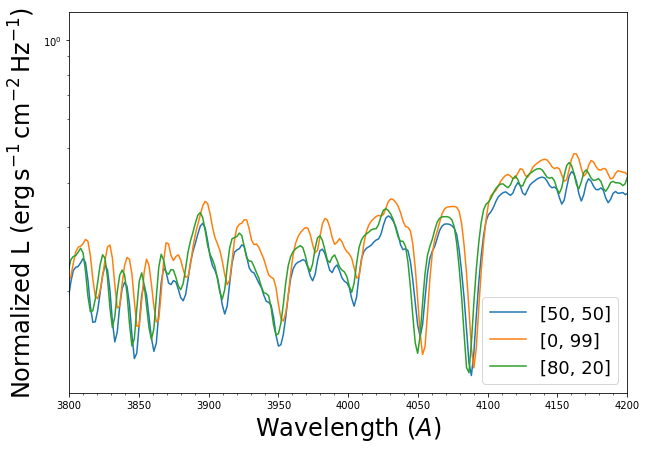

In [29]:
pixels = [[50,50],[0,99],[80,20]]
fig = plt.figure(figsize=(10, 7))
ax = plt.gca()
for loop, f in enumerate(pixels):
    ax.plot(wavelength, IFU[:,f[1],f[0]]/IFU[1500,f[1],f[0]], color='C{0}'.format(loop), label='{0}'.format(f))
ax.legend(loc='lower right', fontsize=18)
ax.set_yscale('log')
#ax.set_ylim([1e-23, 5e-21])
ax.set_xlabel(r'Wavelength ($A$)', fontsize=24)
ax.set_ylabel(r'Normalized L ($\mathrm{erg\,s^{-1}\,cm^{-2}\,Hz^{-1}}$)', fontsize=24)
ax.minorticks_on()
plt.xlim([3800,4200])
plt.show()

In [62]:
lines = [sed_interp.OII,sed_interp.NeIII,sed_interp.Hg,sed_interp.Hb,sed_interp.Ha,sed_interp.OIII_4959,sed_interp.OIII_5007,sed_interp.HeI,sed_interp.OI_6302,
         sed_interp.NII_6549,sed_interp.NII_6583,sed_interp.SII_6716,sed_interp.SII_6731]
amplist = []
mod = Sersic2D(amplitude = 1., r_eff = 35, n=1, x_0=50, y_0=50, ellip=1.-np.sqrt(0.75), theta=57.3*np.pi/180)
x,y = np.meshgrid(np.arange(100), np.arange(100))
sbp_line_fidutial =  mod(x, y)
sbp_line_fidutial *= 1./np.sum(sbp_line_fidutial)
with open("{0}/templates/line_test.csv".format(sed_interp.template_path), mode='r') as infile:
    reader = csv.reader(infile)
    with open("/Users/liruancun/Desktop/fake.csv", mode='w') as outfile:
        writer = csv.writer(outfile)
        mydict = dict((rows[0],float(rows[1])) for rows in reader)
C_unit = mydict['SSP1C_unit']
for line in lines:
    if line['name'] == 'NaD':
        amplist.append(sbp_line_fidutial*mydict['HeIa1amplitude']/C_unit)
    else:
        amplist.append(sbp_line_fidutial*mydict['{0}n1amplitude'.format(line['name'])]/C_unit)

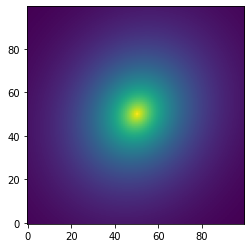

In [63]:
plt.imshow(sbp_line_fidutial,origin='lower')


In [64]:
sigmap = np.ones((100,100))*3.5*sed_interp.c/sed_interp.OIII_5007['wave']
IFU_tot = IFU+Mygalaxy.emission_line(wavelength,lines,amplist,sigmap)

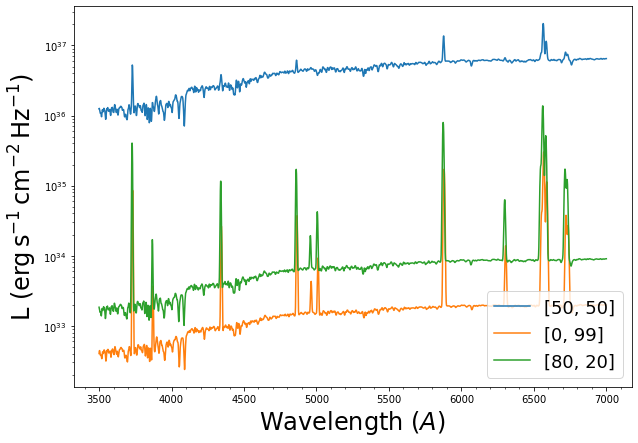

In [65]:
pixels = [[50,50],[0,99],[80,20]]
fig = plt.figure(figsize=(10, 7))
ax = plt.gca()
for loop, f in enumerate(pixels):
    ax.plot(wavelength, IFU_tot[:,f[1],f[0]], color='C{0}'.format(loop), label='{0}'.format(f))
ax.legend(loc='lower right', fontsize=18)
ax.set_yscale('log')
#ax.set_ylim([1e-23, 5e-21])
ax.set_xlabel(r'Wavelength ($A$)', fontsize=24)
ax.set_ylabel(r'L ($\mathrm{erg\,s^{-1}\,cm^{-2}\,Hz^{-1}}$)', fontsize=24)
ax.minorticks_on()
plt.show()
